In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt # to handle dates and time
from datetime import datetime, timedelta, date

from functools import reduce

# data visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#import cufflinks as cf
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import MiniBatchKMeans

from sodapy import Socrata

In [129]:
N=2000

In [130]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy. I used 500000 for the notebook.
results = client.get("fhrw-4uyv", complaint_type = 'Noise - Residential', limit=N)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [132]:
reason_lst = results_df['descriptor'].value_counts()

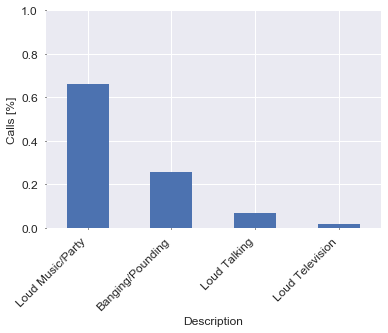

In [133]:
plt.figure(figsize=(6,4))

plt.subplot(1,1,1)
data = reason_lst
data.plot(kind='bar')
plt.xlabel('Description', fontsize=12)
plt.ylabel('Calls [%]', fontsize=12)
plt.tick_params(direction='out', length=1, width=1, labelsize=12)
plt.xticks(rotation=45,horizontalalignment='right')

plt.ylim(0,N)
ax = plt.gca()
ax.set_yticks(np.arange(0,1.2*N,N/5.))
ax.set_yticklabels(np.arange(0,1.2,1/5.))

#plt.savefig('calls_dist.pdf',bbox_inches='tight')
plt.show()

In [134]:
results_df['created_date'] = pd.to_datetime(results_df['created_date'])
results_df['closed_date'] = pd.to_datetime(results_df['closed_date'])
results_df['reaction_time'] = results_df['closed_date'] - results_df['created_date'] 

In [135]:
x = results_df['reaction_time'].dt.total_seconds()/60

In [136]:
call_time = []
for cat in reason_lst.index:
    x_data = results_df[results_df['descriptor'] == cat]
    x = x_data['created_date'].dt.time.apply(lambda x: (x.hour + 18 + x.minute/60.)%24)
    call_time.append(x)

In [137]:
h = range(0,24,3)
hs = ((np.array(h) + 6)%24).tolist()
print(h,hs)

([0, 3, 6, 9, 12, 15, 18, 21], [6, 9, 12, 15, 18, 21, 0, 3])


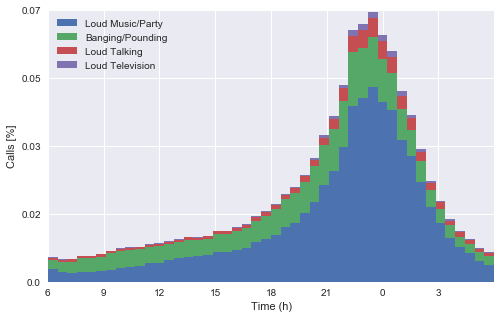

In [144]:
plt.figure(figsize=(8,5))

plt.hist([call_time[0],call_time[1],call_time[2],call_time[3]], stacked = True, bins=23*2)

plt.ylim(0,N/15)
plt.xlim(0,24)
plt.xlabel('Time (h)')
plt.ylabel('Calls [%]')
plt.legend(reason_lst.index)

ax = plt.gca()
ax.set_xticks(h)
ax.set_xticklabels(hs)
ax.set_yticks(np.arange(0,N/15,N/60))
ax.set_yticklabels(np.round(np.arange(0,1,1/60.),2))

#plt.savefig('call_hist.pdf',bbox_inches='tight')
plt.show()

In [139]:
results_df['x_coordinate_state_plane'] = results_df['x_coordinate_state_plane'].values.astype(int)
results_df['y_coordinate_state_plane'] = results_df['y_coordinate_state_plane'].values.astype(int)

In [140]:
x_lim = (results_df['x_coordinate_state_plane']>970000)&(results_df['x_coordinate_state_plane']<1060000)
y_lim = (results_df['y_coordinate_state_plane']>150000)&(results_df['y_coordinate_state_plane']<270000)

results_df = results_df[x_lim & y_lim]

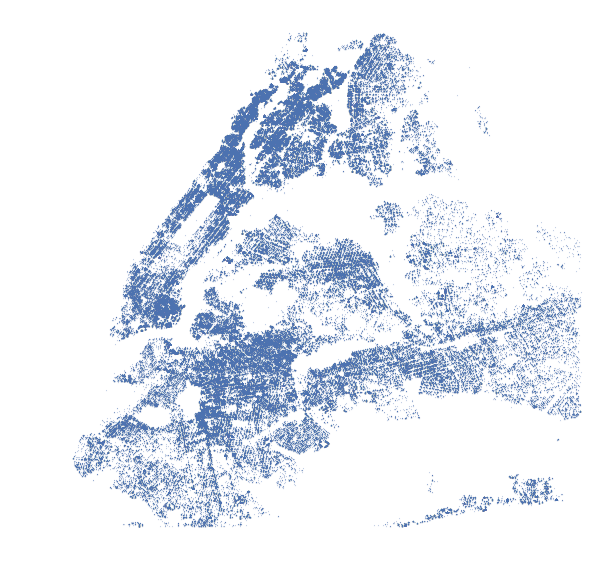

In [141]:
plt.figure(figsize=(10,10))

plt.scatter(x=results_df['x_coordinate_state_plane'].values,y=results_df['y_coordinate_state_plane'].values, marker='^',s=1,alpha=.3)
#plt.xlim([970000,1060000])
#plt.ylim([150000, 270000])
plt.axis('off')
plt.show()

In [145]:
coords = results_df[['x_coordinate_state_plane','y_coordinate_state_plane']].values

In [146]:
sample_ind = np.random.permutation(len(coords))[:N]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [147]:
results_df.loc[:, 'noise_cluster'] = kmeans.predict(results_df[['x_coordinate_state_plane','y_coordinate_state_plane']])

In [148]:
top3noise = results_df['noise_cluster'].value_counts()[:3]
top3noise

28    13850
37    11691
15    11528
Name: noise_cluster, dtype: int64

In [149]:
noise_dict = {k: v for v, k in enumerate(top3noise.index)}
noise_dict

{15: 2, 28: 0, 37: 1}

In [150]:
top3_df = results_df[results_df['noise_cluster'].isin(list(top3noise.index))]
top3_df['noise_cluster'].replace(noise_dict, inplace=True)

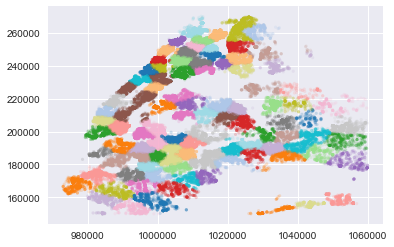

In [151]:
n=N/10;

plt.figure(figsize=(10,10));

fig, ax = plt.subplots(ncols=1, nrows=1);
ax.scatter(results_df.x_coordinate_state_plane.values[:n], results_df.y_coordinate_state_plane.values[:n], s=10, lw=0,
           c=results_df.noise_cluster[:n].values, cmap='tab20', alpha=0.2);
#ax.set_xlim(city_long_border)
#ax.set_ylim(city_lat_border)
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')
plt.show();

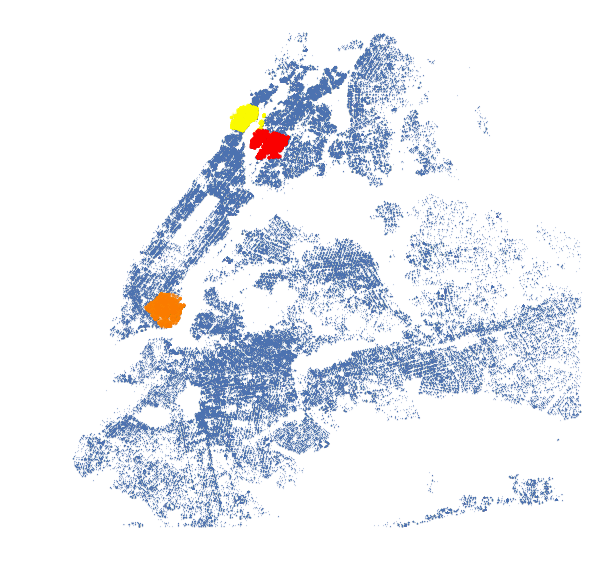

In [152]:
n=N/10;

plt.figure(figsize=(10,10))

plt.scatter(x=results_df['x_coordinate_state_plane'].values,y=results_df['y_coordinate_state_plane'].values, marker='^',s=1,alpha=.3)

plt.scatter(top3_df.x_coordinate_state_plane.values[:n], top3_df.y_coordinate_state_plane.values[:n], s=10, lw=0,
           c=top3_df.noise_cluster[:n].values, cmap='autumn', alpha=0.2);

plt.axis('off')
#plt.savefig('noisy.pdf',bbox_inches='tight')
plt.show()